In [2]:
#Boiler plate imports
import pandas as pd
import sys
from time import time
import matplotlib.pyplot as plt
import numpy as np
import os

#SBND imports
s0 = time()
sys.path.append('/exp/sbnd/app/users/brindenc/analyze_sbnd/pyana')
from sbnd.cafclasses.slice import CAFSlice
from sbnd.xsec import response

#Constants
from sbnd.numu.numu_constants import *
from sbnd.constants import *
from sbnd.flux.constants import *

#Plotters
from sbnd.plotlibrary import makeplot
from sbnd.general import plotters

s1 = time()
print(f'SBND imports: {s1-s0:.2f} s')

%load_ext autoreload
%autoreload 2

SBND imports: 1.35 s


## 1. Constants/Variables

In [3]:
#Constants/variables
CUT_MODE = 'roc'
#DATA_DIR  = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v09_78_04_wc_pandora'
#DATA_DIR = '/exp/sbnd/data/users/brindenc/ML/test_fcl/debug_trackid/v4'
DATA_DIR = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v09_82_02_01_pds_gain'
FNAME = f'nom_processed_{CUT_MODE}.df'
HDR_FNAME = 'nom.df'
#FNAME = f'single_processed_{CUT_MODE}.df'
#FNAME = 'single_cut_cosmics_processed.df'
#HDR_FNAME = 'single.df'
#FNAME = f'all_processed_{CUT_MODE}.df'
#FNAME = 'all_processed_roc.df'
#HDR_FNAME = 'all.df'
#FNAME = 'test_processed.df'
#HDR_FNAME = 'test.df'
#NOM_POT = 0.6e20 # stats for first run
LABEL = 'SBND Work in Progress\n0.6e20 POT'
PLOT_DIR = f'Plots/reco_{plotters.day}_{CUT_MODE}/xsec'
SAVE_PLOT = True

#For saving smearing_matrices
SMEARING_DIR = 'data/smearing_matrices'

## 2. Load/Clean Data

### 2.1 Load Data

In [4]:
#Get data and POT
slc = CAFSlice.load(f'{DATA_DIR}/{FNAME}','slice')
hdr = pd.read_hdf(f'{DATA_DIR}/{HDR_FNAME}',key='hdr')
SAMPLE_POT = hdr.pot.sum()

#Scale to nominal POT
print(f'--scaled by {NOM_POT/SAMPLE_POT:.2f}')
slc.scale_to_pot(NOM_POT,SAMPLE_POT)

--scaled by 8.05
--scaling to POT: 7.45e+18 -> 6.00e+19


In [5]:
CUTS = ['cosmic','fv','trk','has_muon']
pur,eff,f1 = slc.get_pur_eff_f1(['cosmic','fv','trk','has_muon'])
pur,eff,f1

(array([0.22224323, 0.66998959, 0.81309471, 0.85877658, 0.92076491]),
 array([1.        , 0.7206205 , 0.61017594, 0.57319694, 0.49579174]),
 array([1.        , 0.69438333, 0.69717004, 0.68751007, 0.64453142]))

### 2.2 Assign binning

In [6]:
#First assign binnings, to get efficiency per bin - use truth value
slc.assign_bins(COSTHETA_BINS,'best_muon.costheta',assign_key='best_muon.costheta_bin')
slc.assign_bins(COSTHETA_BINS,'best_muon.truth.p.costheta',assign_key='best_muon.truth.costheta_bin')

In [7]:
momentum_bins = np.array([0.,0.2,0.3,0.5,0.8,1.3,2.5])
slc.assign_bins(momentum_bins,'best_muon.p',assign_key='best_muon.momentum_bin')
slc.assign_bins(momentum_bins,'best_muon.truth.p.genp.tot',assign_key='best_muon.truth.momentum_bin')

## 3. Smearing Matrix

In [8]:
slc_cut = slc.copy()
for c in CUTS:
    slc_cut.apply_cut(f'cut.{c}')

Applied cut on key: cut.cosmic (201,014 --> 48,050)
Applied cut on key: cut.fv (48,050 --> 33,525)
Applied cut on key: cut.trk (33,525 --> 29,818)
Applied cut on key: cut.has_muon (29,818 --> 24,055)


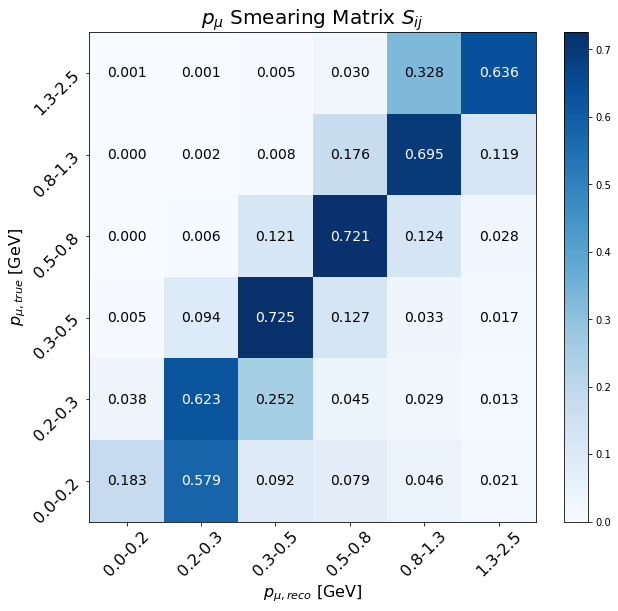

In [9]:
reco_bins = slc_cut.data.best_muon.momentum_bin
true_bins = slc_cut.data.best_muon.truth.momentum_bin

momentum_smearing_matrix = response.calc_smearing_matrix(reco_bins,true_bins,normalize=True)

#Make quick smearing matrix plot - 2d hist
tick_names = [f'{momentum_bins[i]}-{momentum_bins[i+1]}' for i in range(len(momentum_bins)-1)]
fig,ax = makeplot.draw_confusion_matrix_binned(momentum_smearing_matrix,class_names=tick_names,show_counts=False,xlabel=r'$p_{\mu,reco}$ [GeV]',ylabel=r'$p_{\mu,true}$ [GeV]',
                                      figsize=(10,9))
ax.set_title(r'$p_\mu$ Smearing Matrix $S_{ij}$')
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('momentum_smearing_matrix',folder_name=PLOT_DIR)

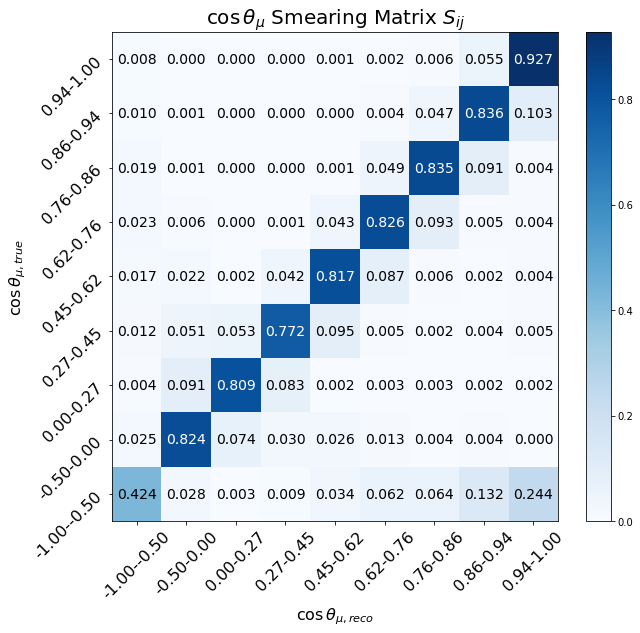

In [10]:
reco_bins = slc_cut.data.best_muon.costheta_bin
true_bins = slc_cut.data.best_muon.truth.costheta_bin
costheta_smearing_matrix = response.calc_smearing_matrix(reco_bins,true_bins,normalize=True)

#Make quick 2d hist
tick_names = [f'{COSTHETA_BINS[i]:.2f}-{COSTHETA_BINS[i+1]:.2f}' for i in range(len(COSTHETA_BINS)-1)]
fig,ax = makeplot.draw_confusion_matrix_binned(costheta_smearing_matrix,class_names=tick_names,show_counts=False,xlabel=r'$\cos\theta_{\mu,reco}$',ylabel=r'$\cos\theta_{\mu,true}$',
                                        figsize=(10,9))
ax.set_title(r'$\cos\theta_\mu$ Smearing Matrix $S_{ij}$')
plotters.set_style(ax)
if SAVE_PLOT:
    plotters.save_plot('costheta_smearing_matrix',folder_name=PLOT_DIR)

In [11]:
#Save
os.makedirs(SMEARING_DIR,exist_ok=True)

np.savetxt(f'{SMEARING_DIR}/momentum.csv',momentum_smearing_matrix)
np.savetxt(f'{SMEARING_DIR}/costheta.csv',costheta_smearing_matrix)

## 4. Response efficeincies

### 4.1 For total XSec

In [12]:
#Get signal and cuts
slc_numucc = slc.copy()
slc_numucc.data = slc.data[(slc.data.truth.event_type==0).values]
slc_numucc_cut = slc_numucc.copy()
for cut in CUTS:
    slc_numucc_cut.apply_cut(cut)

#Get number selected and generated 
ngens = slc_numucc.get_numevents()
nsels = slc_numucc_cut.get_numevents()


Applied cut on key: cut.cosmic (44,674 --> 32,193)
Applied cut on key: cut.fv (32,193 --> 27,259)
Applied cut on key: cut.trk (27,259 --> 25,607)
Applied cut on key: cut.has_muon (25,607 --> 22,149)


In [13]:
#Check
print(f'{round(ngens):,}   {round(nsels):,}')

359,551   178,262


In [14]:
# Get the efficiency - it'll just be the normal efficiency
eff = nsels/ngens
eff

0.495791735685186

### 4.2 For Single Differential XSec

In [15]:
COSTHETA_BINS,MOMENTUM_BINS

(array([-1.  , -0.5 ,  0.  ,  0.27,  0.45,  0.62,  0.76,  0.86,  0.94,
         1.  ]),
 array([0. , 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 2. , 3. ]))

In [16]:
# Get signal and bin
slc_numucc = slc.copy()
slc_numucc.data = slc.data[(slc.data.truth.event_type==0).values]



slc_numucc_cut = slc_numucc.copy()
for cut in CUTS:
    slc_numucc_cut.apply_cut(cut)

Applied cut on key: cut.cosmic (44,674 --> 32,193)
Applied cut on key: cut.fv (32,193 --> 27,259)
Applied cut on key: cut.trk (27,259 --> 25,607)
Applied cut on key: cut.has_muon (25,607 --> 22,149)
